In [28]:
import os
import pydicom
import highdicom
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy

In [29]:
SLICE_FOLDER = '../data/RadCTTACEomics_1685/1685/10_AP_Ax2.50mm/'

# load dicom slice files
slices = [pydicom.dcmread(os.path.join(SLICE_FOLDER, f)) 
          for f in os.listdir(SLICE_FOLDER) if f.endswith('.dcm')]

# sort slices by SliceLocation (or InstanceNumber)
slices.sort(key=lambda x: int(x.SliceLocation))

# Stack into 3D volume
img_dcm = np.stack([s.pixel_array for s in slices], axis=0)

img_dcm.shape

(86, 512, 512)

In [30]:
segm_ds = pydicom.dcmread('../data/RadCTTACEomics_1685/1685/10_AP_Ax2.50mm_ManualROI_Tumor.dcm')

tumor = np.zeros_like(img_dcm)

for i, frame in enumerate(segm_ds.PerFrameFunctionalGroupsSequence):
    # print(int(frame.DerivationImageSequence[0].SourceImageSequence[0].ReferencedFrameNumber))
    # copy the tumor slice into the same shaped tumor matrix to rotate
    index = int(frame.DerivationImageSequence[0].SourceImageSequence[0].ReferencedFrameNumber)
    # tumor[index - 1, ...] = np.where(segm_ds.pixel_array[i, ...] == 1, img_dcm[index - 1, ...], 0)
    tumor[index - 1, ...] = segm_ds.pixel_array[i, ...]

tumor.shape

(86, 512, 512)

In [31]:
import scipy.ndimage

labeled, num_features = scipy.ndimage.label(tumor)
centroids = scipy.ndimage.center_of_mass(tumor, labeled, range(1, num_features + 1))

bboxes = []

for i in range(1, num_features + 1):
    coords = np.argwhere(labeled == i)
    z_min, y_min, x_min = coords.min(axis=0)
    z_max, y_max, x_max = coords.max(axis=0)
    # Add +1 to max to make it an exclusive upper bound, like slicing
    bboxes.append((z_min, y_min, x_min, z_max + 1, y_max + 1, x_max + 1))

In [32]:
bboxes[0]

(np.int64(26),
 np.int64(155),
 np.int64(262),
 np.int64(31),
 np.int64(173),
 np.int64(277))

In [33]:
def MIP_sagittal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the maximum intensity projection on the sagittal orientation. """
    return np.max(img_dcm, axis=2)

def MIP_coronal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the maximum intensity projection on the coronal orientation. """
    return np.max(img_dcm, axis=1)

def rotate_on_axial_plane(img_dcm: np.ndarray, angle_in_degrees: float) -> np.ndarray:
    """ Rotate the image on the axial plane. """
    return scipy.ndimage.rotate(img_dcm, angle_in_degrees, axes=(1, 2), reshape=False)

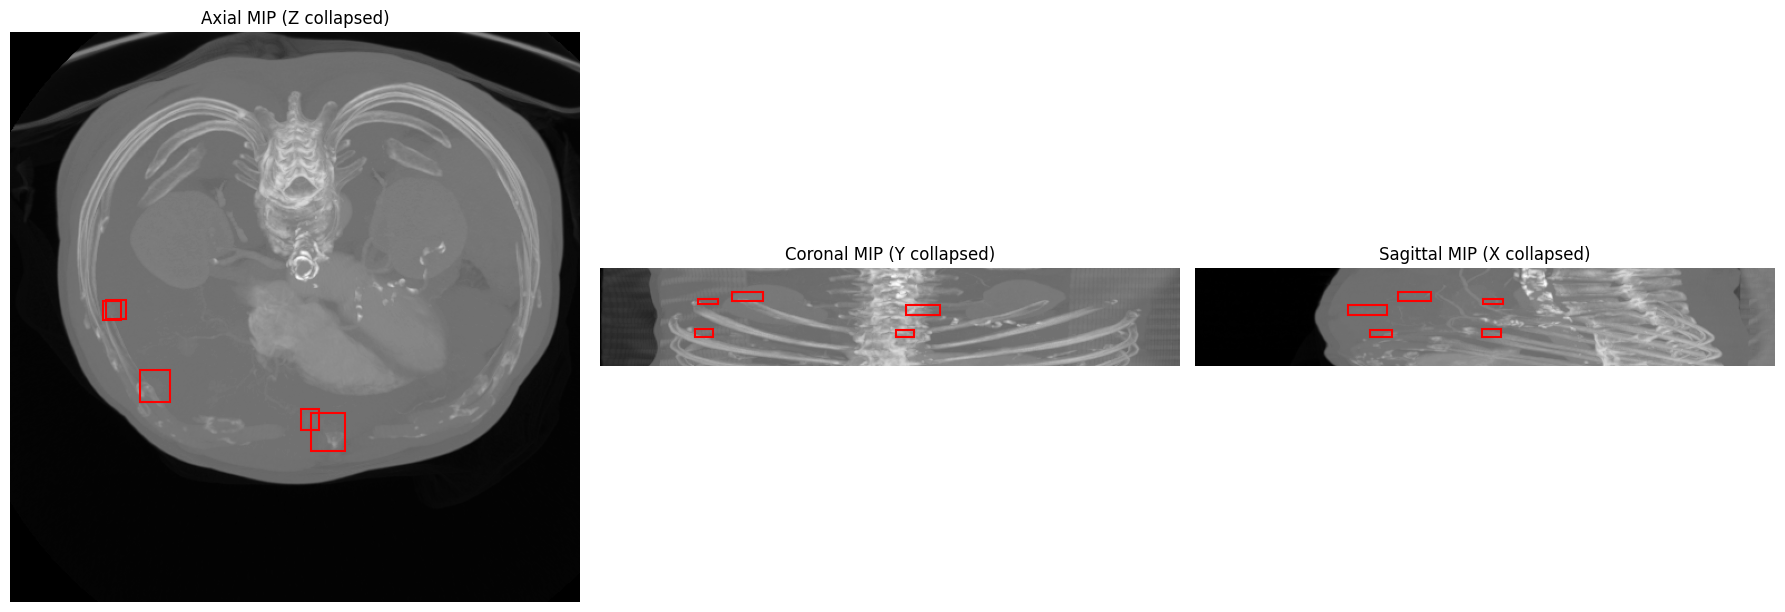

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label

def get_3d_bounding_boxes(mask):
    """
    Get 3D bounding boxes for connected components in the mask.
    Each bbox is (zmin, ymin, xmin, zmax, ymax, xmax)
    """
    labeled_mask, num_features = label(mask)
    bboxes = []
    for i in range(1, num_features + 1):
        coords = np.argwhere(labeled_mask == i)
        zmin, ymin, xmin = coords.min(axis=0)
        zmin -= 1
        ymin -= 1
        xmin -= 1
        zmax, ymax, xmax = coords.max(axis=0)
        zmax += 1
        ymax += 1
        xmax += 1
        bboxes.append((zmin, ymin, xmin, zmax, ymax, xmax))
    return bboxes

def plot_mip_with_bboxes(image, bboxes):
    """
    Plot MIP projections of the 3D image and overlay bounding boxes on each.
    """
    # Compute MIPs
    mip_axial = np.max(image, axis=0)     # Z collapsed → (Y, X)
    mip_coronal = np.max(image, axis=1)   # Y collapsed → (Z, X)
    mip_sagittal = np.max(image, axis=2)  # X collapsed → (Z, Y)

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # --- Axial MIP (view from top) ---
    axs[0].imshow(mip_axial, cmap='gray', origin='lower')
    axs[0].set_title("Axial MIP (Z collapsed)")
    for zmin, ymin, xmin, zmax, ymax, xmax in bboxes:
        width = xmax - xmin
        height = ymax - ymin
        rect = plt.Rectangle((xmin, ymin), width, height, edgecolor='red', facecolor='none', linewidth=1.5)
        axs[0].add_patch(rect)

    # --- Coronal MIP (view from front) ---
    axs[1].imshow(mip_coronal, cmap='gray', origin='lower')
    axs[1].set_title("Coronal MIP (Y collapsed)")
    for zmin, ymin, xmin, zmax, ymax, xmax in bboxes:
        width = xmax - xmin
        height = zmax - zmin
        rect = plt.Rectangle((xmin, zmin), width, height, edgecolor='red', facecolor='none', linewidth=1.5)
        axs[1].add_patch(rect)

    # --- Sagittal MIP (view from side) ---
    axs[2].imshow(mip_sagittal, cmap='gray', origin='lower')
    axs[2].set_title("Sagittal MIP (X collapsed)")
    for zmin, ymin, xmin, zmax, ymax, xmax in bboxes:
        width = ymax - ymin
        height = zmax - zmin
        rect = plt.Rectangle((ymin, zmin), width, height, edgecolor='red', facecolor='none', linewidth=1.5)
        axs[2].add_patch(rect)

    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
# Load original 3D image and binary mask (both np.ndarray, shape (Z, Y, X))
#image = np.load("ct_image.npy")
#mask = np.load("segmentation_mask.npy")

# Compute bounding boxes from mask
bboxes = get_3d_bounding_boxes(tumor)

# Plot MIP views with bounding boxes
plot_mip_with_bboxes(img_dcm, bboxes)


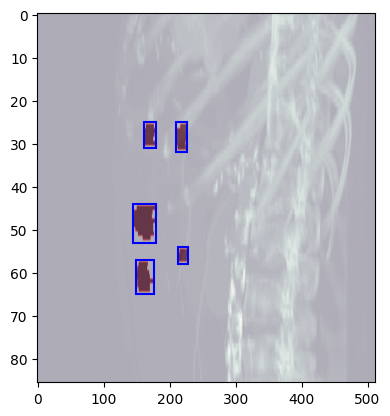

In [35]:
pixel_len_mm = [float(slices[0].SliceThickness), float(slices[0].PixelSpacing[0]), slices[0].PixelSpacing[1]]

# Create projections varying the angle of rotation
#   Configure visualization colormap
img_min = np.amin(img_dcm)
img_max = np.amax(img_dcm)

mask_min = np.amin(tumor)
mask_max = np.amax(tumor)

cm = matplotlib.colormaps['bone']
fig, ax = plt.subplots()
#   Configure directory to save results
os.makedirs('results/MIP/', exist_ok=True)
#   Create projections
n = 24
for idx, alpha in enumerate(np.linspace(0, 360*(n-1)/n, num=n)):

    # Rotate and show the original CT image
    rotated_img = rotate_on_axial_plane(img_dcm, alpha)
    projection = MIP_sagittal_plane(rotated_img)
    
    # Rotate and show the tumor mask
    rotated_mask = rotate_on_axial_plane(tumor, alpha)
    projection_mask = MIP_sagittal_plane(rotated_mask)
    
    # Plot the CT image
    plt.imshow(projection, cmap=cm, vmin=img_min, vmax=img_max, aspect=pixel_len_mm[0] / pixel_len_mm[1])

    # Overlay the tumor mask
    # plt.imshow(np.ma.masked_where(projection_mask == 0, projection), cmap='Set1', alpha=0.5, vmin=img_min, vmax=img_max, aspect=pixel_len_mm[0] / pixel_len_mm[1])
    plt.imshow(projection_mask, cmap='Reds', alpha=0.5, vmin=mask_min, vmax=mask_max, aspect=pixel_len_mm[0] / pixel_len_mm[1])

    bboxes = get_3d_bounding_boxes(rotated_mask)

    # Clear previous bounding boxes
    for patch in plt.gca().patches:
        patch.remove()

    # Draw bounding boxes on the projection mask
    for zmin, ymin, xmin, zmax, ymax, xmax in bboxes:
        plt.gca().add_patch(plt.Rectangle((ymin, zmin), ymax - ymin, zmax - zmin, edgecolor='blue', facecolor='none', linewidth=1.5))

    # Save the combined projection
    plt.savefig(f'results/MIP/Projection_{idx}.png')


In [36]:
import imageio

# Define the directory containing the PNG images
image_folder = 'results/MIP/'

# Get the list of PNG files in the folder
png_files = [os.path.join(image_folder, f'Projection_{idx}.png') for idx in range(n)]

# Create a GIF from the PNG files
gif_path = 'results/MIP/Projections.gif'
with imageio.get_writer(gif_path, mode='I', duration=0.25, loop=0) as writer:
    for png_file in png_files:
        image = imageio.imread(png_file)
        writer.append_data(image)

print(f"GIF saved at {gif_path}")

/tmp/ipykernel_14949/3637838589.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(png_file)


GIF saved at results/MIP/Projections.gif
